In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [2]:
load_dotenv()

True

In [3]:
DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

In [4]:
sql_query = """
SELECT
	DATE_TRUNC('month', TO_DATE(date, 'DD.MM.YYYY'))::date AS month,
	SUM(value) AS total_value
FROM takemehome.prognostica_daten_kunden 
WHERE customer NOT LIKE '&DEK'
GROUP BY "month"
ORDER BY month;
"""

In [5]:
df = pd.read_sql(sql_query, db)

In [6]:
df.head()

,month,total_value
0,2005-07-01,7194.0
1,2005-08-01,7202.0
2,2005-09-01,7290.0
3,2005-10-01,7280.0
4,2005-11-01,7270.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        117 non-null    object 
 1   total_value  117 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [8]:
df['month'] = pd.to_datetime(df['month'])
df.head()

,month,total_value
0,2005-07-01,7194.0
1,2005-08-01,7202.0
2,2005-09-01,7290.0
3,2005-10-01,7280.0
4,2005-11-01,7270.0


In [9]:
df = df.sort_values('month')
df = df.set_index('month')
df.head(10)

,total_value
month,
2005-07-01,7194.0
2005-08-01,7202.0
2005-09-01,7290.0
2005-10-01,7280.0
2005-11-01,7270.0
2005-12-01,7312.0
2006-01-01,7336.0
2006-02-01,7358.0
2006-03-01,7348.0


In [10]:
df.index.freq
df = df.asfreq('MS')

<Axes: title={'center': 'Monthly Revenue'}, xlabel='month'>

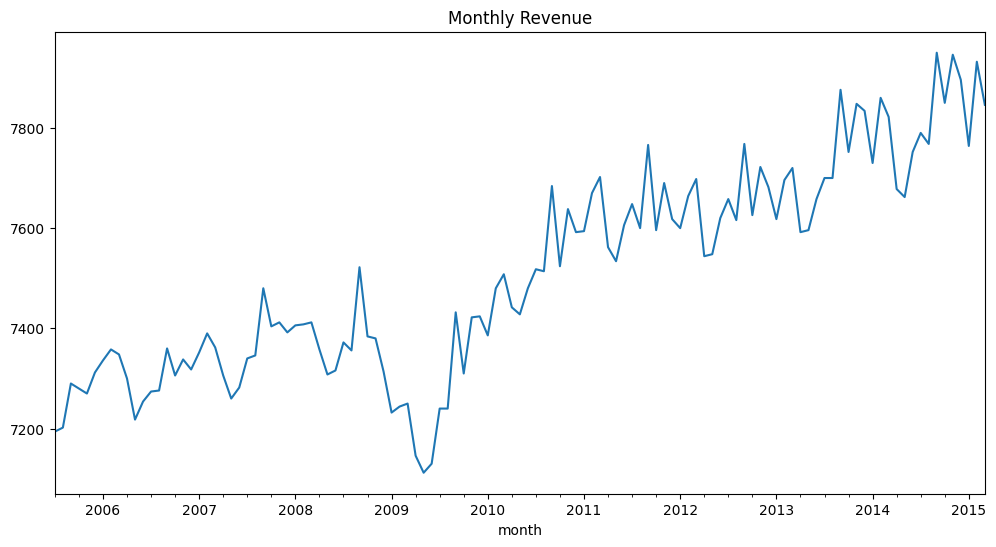

In [11]:
df['total_value'].plot(figsize=(12,6), title="Monthly Revenue")

<Axes: xlabel='month'>

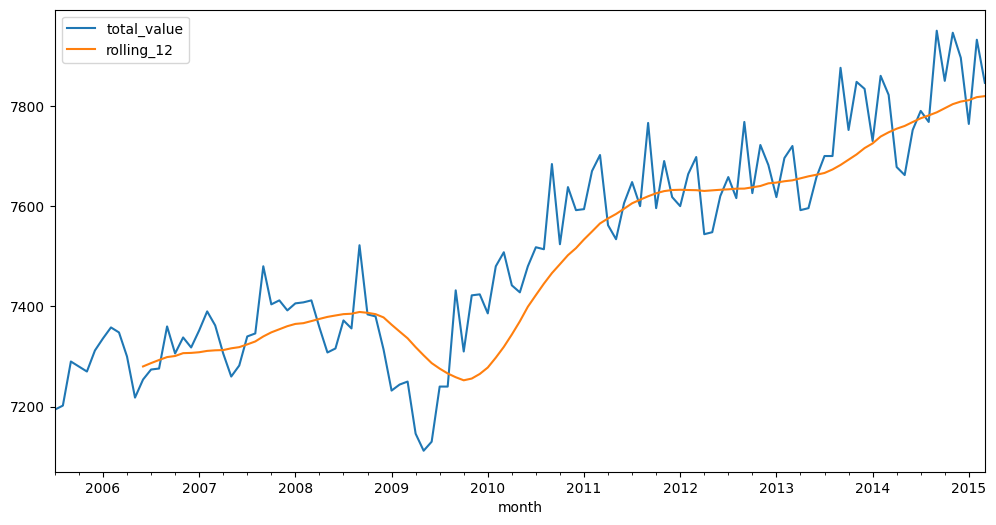

In [12]:
df['rolling_12'] = df['total_value'].rolling(12).mean()
df[['total_value','rolling_12']].plot(figsize=(12,6))

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['total_value'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.372081877164898
p-value: 0.5955848451554316


<Axes: title={'center': 'First Difference'}, xlabel='month'>

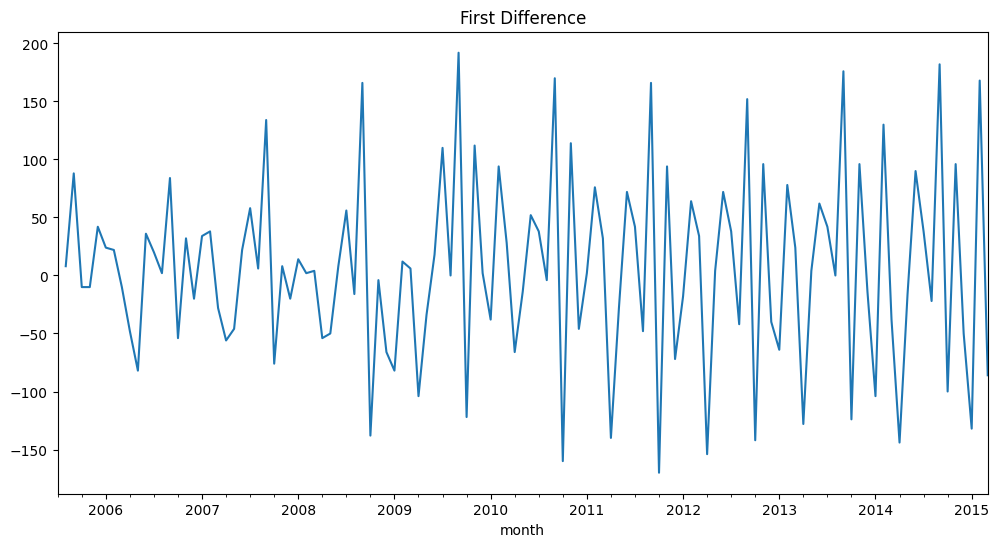

In [14]:
df['diff_1'] = df['total_value'].diff()
df['diff_1'].plot(figsize=(12,6), title="First Difference")

In [15]:
result_diff = adfuller(df['diff_1'].dropna())
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])

ADF Statistic: -2.577348111773607
p-value: 0.09776990786022516


In [16]:
missing = df['total_value'].isna().sum()
missing

0

c:\Users\Josip\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


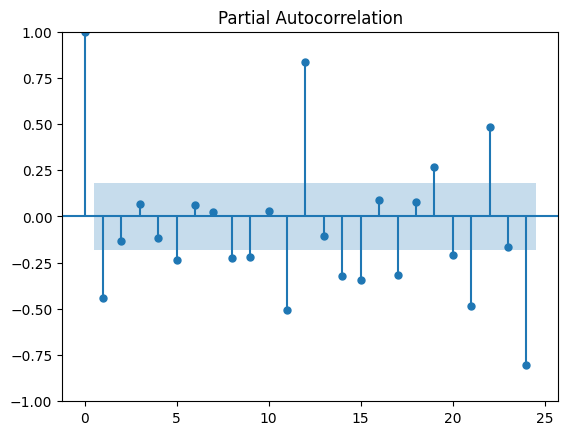

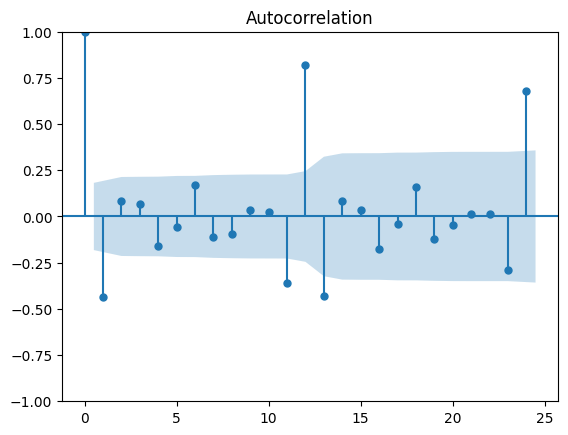

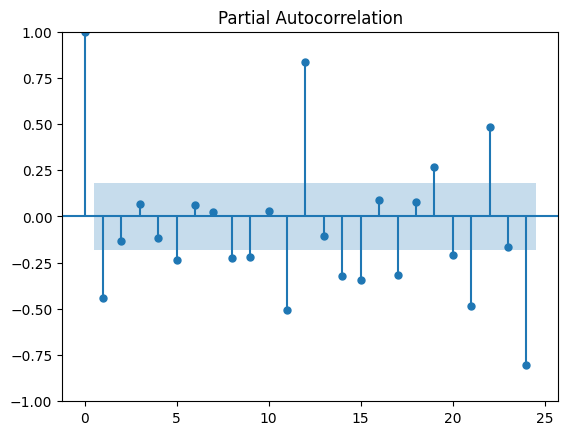

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = df['total_value'].diff().dropna()   # d=1

plot_acf(series, lags=24)
plot_pacf(series, lags=24)

In [18]:
train = df.iloc[:-6]
test = df.iloc[-6:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (111, 3)
Test shape: (6, 3)


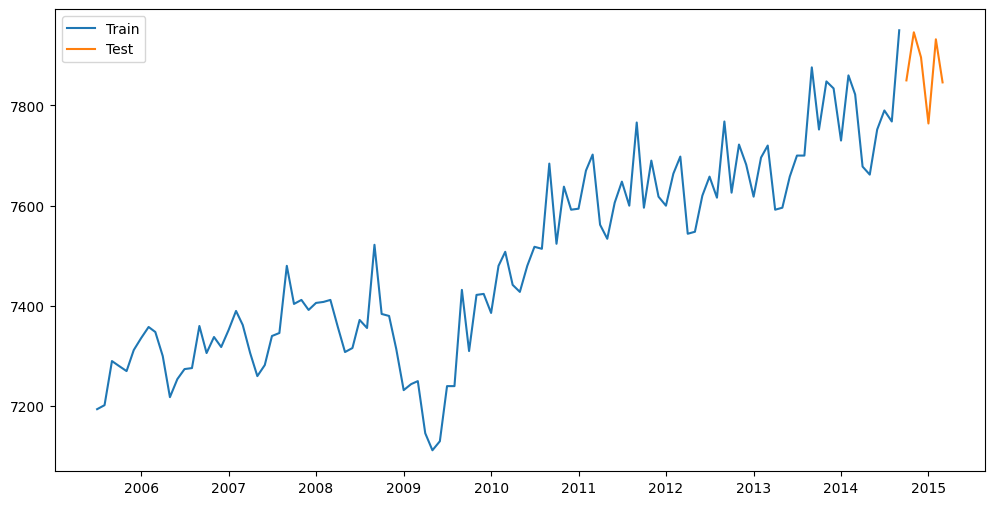

In [19]:
plt.figure(figsize=(12,6))
plt.plot(train['total_value'], label='Train')
plt.plot(test['total_value'], label='Test')
plt.legend()
plt.show()

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['total_value'],
                order=(1,1,1),
                seasonal_order=(1,1,1,12))

result = model.fit()

print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        total_value   No. Observations:                  111
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -480.868
Date:                            Fri, 20 Feb 2026   AIC                            971.736
Time:                                    13:54:44   BIC                            984.661
Sample:                                07-01-2005   HQIC                           976.964
                                     - 09-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7996      0.235      3.407      0.001       0.340       1.260
ma.L1         -0.6566      0.303   

In [21]:
forecast = result.forecast(steps=6)

print(forecast)

2014-10-01    7823.123618
2014-11-01    7918.224528
2014-12-01    7901.124084
2015-01-01    7801.063033
2015-02-01    7926.388624
2015-03-01    7892.873905
Freq: MS, Name: predicted_mean, dtype: float64


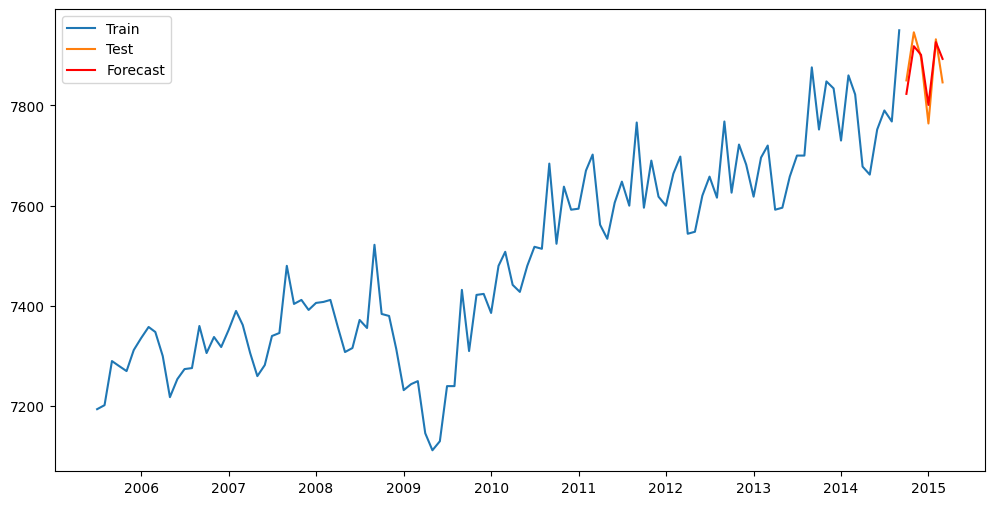

In [22]:
plt.figure(figsize=(12,6))
plt.plot(train['total_value'], label='Train')
plt.plot(test['total_value'], label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

In [23]:
model1 = SARIMAX(train['total_value'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
model2 = SARIMAX(train['total_value'], order=(2,1,1), seasonal_order=(1,1,1,12)).fit()
model3 = SARIMAX(train['total_value'], order=(1,1,2), seasonal_order=(1,1,1,12)).fit()

print(model1.aic, model2.aic, model3.aic)

971.7363306032812 964.1161477976856 961.8890277068081


AIC: 819.6106186017478
MAE:  25.52
RMSE: 29.84
MAPE: 0.33%


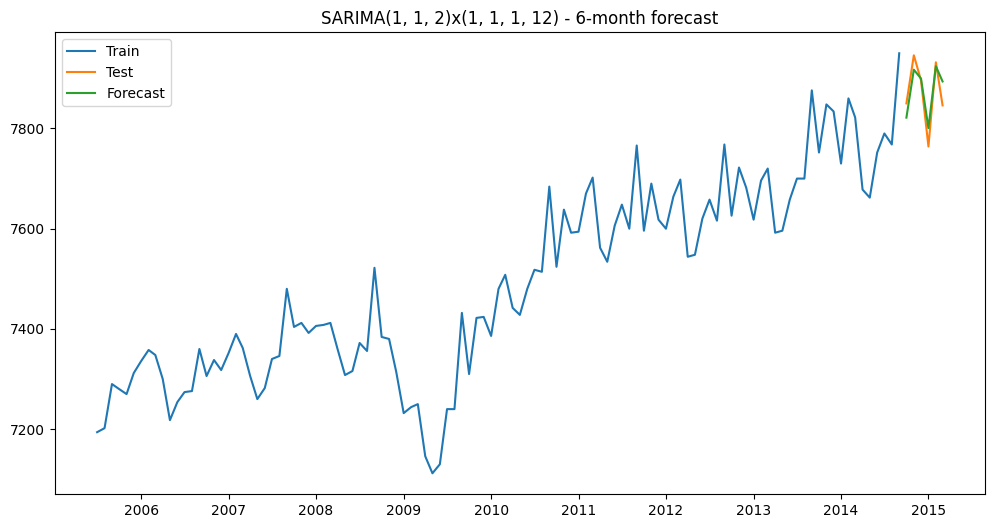

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_order = (1,1,2)            # <-- STAVI OVDJE svoj "treći model" order
best_seasonal = (1,1,1,12)      # <-- i seasonal_order

model = SARIMAX(train['total_value'],
                order=best_order,
                seasonal_order=best_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)

res = model.fit(disp=False)
print("AIC:", res.aic)

forecast = res.forecast(steps=len(test))  # 6

# metrike
mae = np.mean(np.abs(test['total_value'] - forecast))
rmse = np.sqrt(np.mean((test['total_value'] - forecast)**2))
mape = np.mean(np.abs((test['total_value'] - forecast) / test['total_value'])) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# plot
plt.figure(figsize=(12,6))
plt.plot(train['total_value'], label="Train")
plt.plot(test['total_value'], label="Test")
plt.plot(forecast, label="Forecast")
plt.title(f"SARIMA{best_order}x{best_seasonal} - 6-month forecast")
plt.legend()
plt.show()

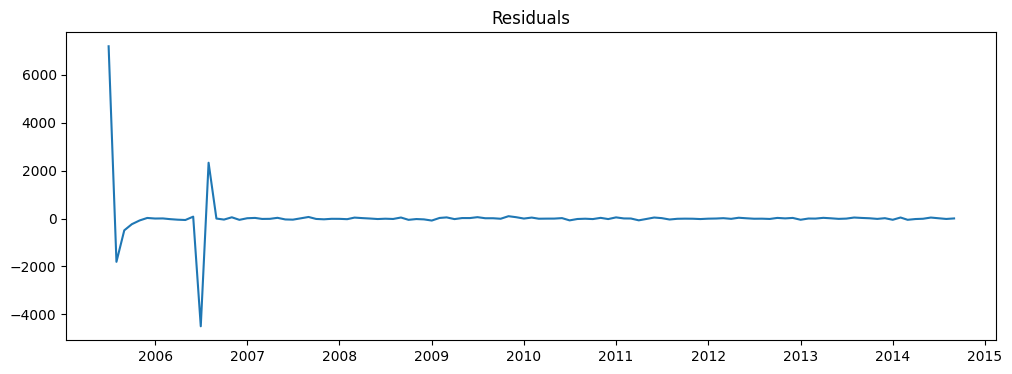

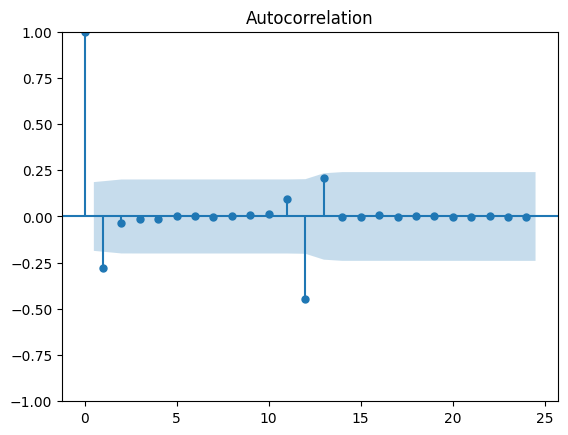

In [25]:
residuals = res.resid
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=24)
plt.show()

In [26]:

final_model = SARIMAX(df['total_value'],
                      order=(1,1,2),
                      seasonal_order=(1,1,1,12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

final_res = final_model.fit(disp=False)

forecast_steps = 6
forecast = final_res.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

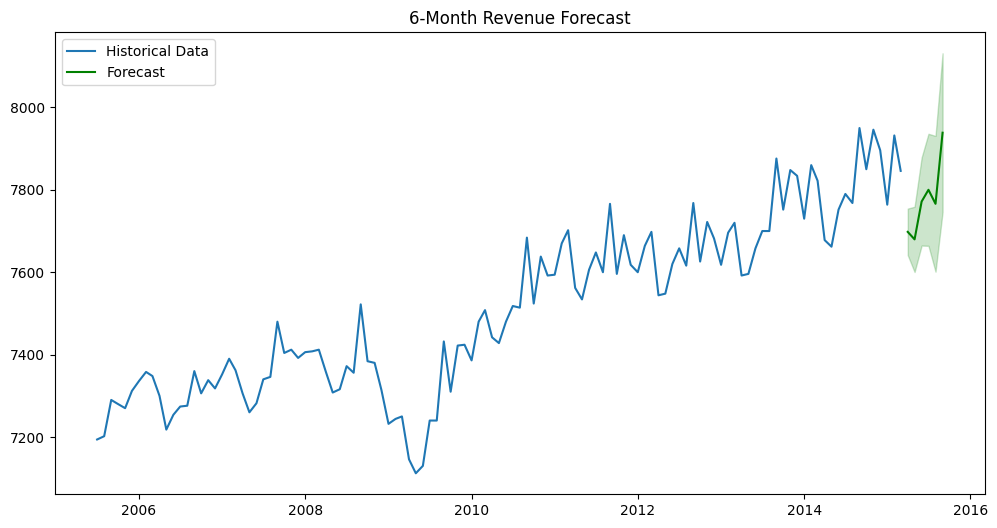

In [27]:
plt.figure(figsize=(12,6))
plt.plot(df['total_value'], label="Historical Data")
plt.plot(forecast_mean, label="Forecast", color='green')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='green',
                 alpha=0.2)

plt.legend()
plt.title("6-Month Revenue Forecast")
plt.show()

In [30]:
sql_afo = """
SELECT
    DATE_TRUNC('month', TO_DATE(date, 'DD.MM.YYYY'))::date AS month,
    value AS afo_index
FROM takemehome.prognostica_afo
ORDER BY month;
"""

df_afo = pd.read_sql(sql_afo, db)
df_afo.head()
df.shape

(117, 3)

In [29]:
df_afo.columns

Index(['month', 'afo_index'], dtype='object')

In [31]:
df_afo.dtypes

month        object
afo_index    object
dtype: object

In [33]:
df_afo['afo_index'] = (
    df_afo['afo_index']
    .str.replace(',', '.', regex=False)
)

df_afo['afo_index'] = pd.to_numeric(df_afo['afo_index'])

df_afo.dtypes

month        datetime64[ns]
afo_index           float64
dtype: object

In [34]:
df_afo = df_afo.sort_values('month')
df_afo = df_afo.set_index('month')

df_afo.head()

,afo_index
month,
2005-07-01,100.18
2005-08-01,100.29
2005-09-01,100.44
2005-10-01,100.51
2005-11-01,100.51


In [37]:
df_full = df.join(df_afo, how="inner")
df_full

,total_value,rolling_12,diff_1,afo_index
month,,,,
2005-07-01,7194.0,NaN,NaN,100.18
2005-08-01,7202.0,NaN,8.0,100.29
2005-09-01,7290.0,NaN,88.0,100.44
2005-10-01,7280.0,NaN,-10.0,100.51
2005-11-01,7270.0,NaN,-10.0,100.51
...,...,...,...,...
2014-11-01,7946.0,7803.500000,96.0,100.56
2014-12-01,7896.0,7808.666667,-50.0,100.44
2015-01-01,7764.0,7811.500000,-132.0,100.30


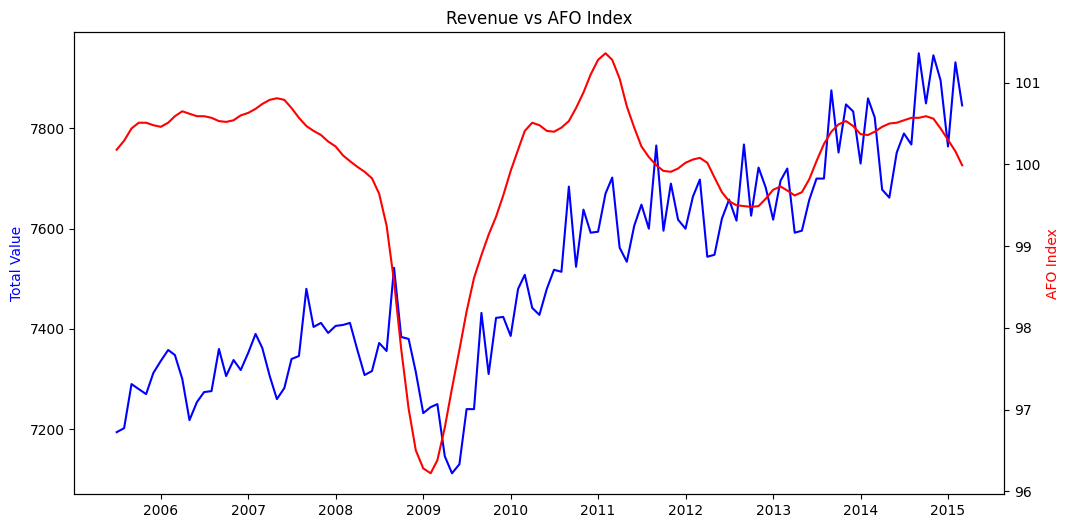

In [38]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Lijeva osa – revenue
ax1.plot(df_full.index, df_full['total_value'], color='blue')
ax1.set_ylabel('Total Value', color='blue')

# Desna osa – AFO
ax2 = ax1.twinx()
ax2.plot(df_full.index, df_full['afo_index'], color='red')
ax2.set_ylabel('AFO Index', color='red')

plt.title("Revenue vs AFO Index")
plt.show()

In [39]:
df_full.corr()

,total_value,rolling_12,diff_1,afo_index
total_value,1.000000,0.915048,0.200490,0.332845
rolling_12,0.915048,1.000000,-0.022601,0.266266
diff_1,0.200490,-0.022601,1.000000,0.082258
afo_index,0.332845,0.266266,0.082258,1.000000


In [40]:
df_full['diff_revenue'] = df_full['total_value'].diff()
df_full['diff_afo'] = df_full['afo_index'].diff()

df_full[['diff_revenue','diff_afo']].corr()

,diff_revenue,diff_afo
diff_revenue,1.000000,0.087919
diff_afo,0.087919,1.000000


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

final_model = SARIMAX(df['total_value'],
                      order=(1,1,2),
                      seasonal_order=(1,1,1,12))

final_res = final_model.fit()

In [42]:
forecast = final_res.get_forecast(steps=6)

forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

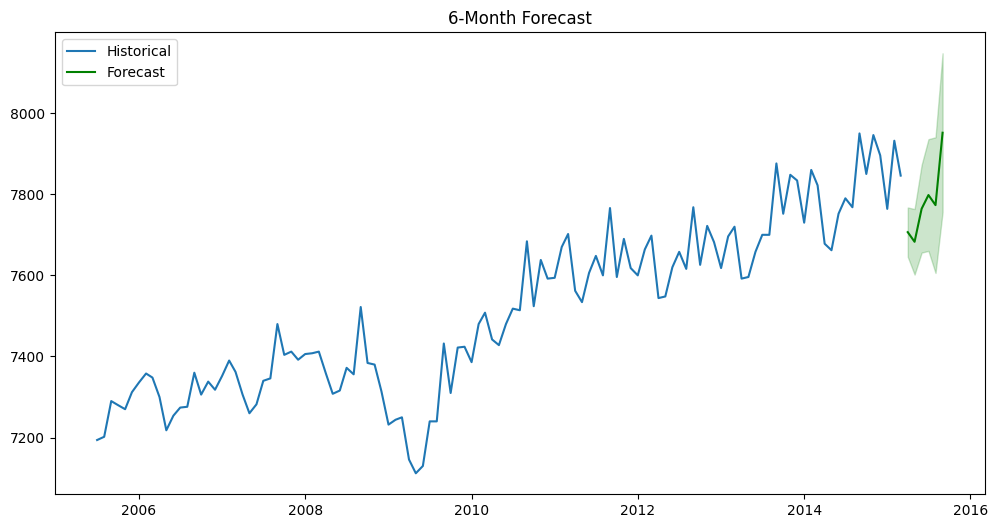

In [43]:
plt.figure(figsize=(12,6))

plt.plot(df['total_value'], label="Historical")
plt.plot(forecast_values, label="Forecast", color="green")

plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='green',
                 alpha=0.2)

plt.legend()
plt.title("6-Month Forecast")
plt.show()

In [44]:
train = df_full.iloc[:-6]
test = df_full.iloc[-6:]

In [45]:
exog_train = train[['afo_index']]
exog_test  = test[['afo_index']]

In [46]:
model_exog = SARIMAX(train['total_value'],
                     exog=exog_train,
                     order=(1,1,2),
                     seasonal_order=(1,1,1,12))

res_exog = model_exog.fit()
print(res_exog.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          total_value   No. Observations:                  111
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -471.741
Date:                              Fri, 20 Feb 2026   AIC                            957.482
Time:                                      14:12:31   BIC                            975.576
Sample:                                  07-01-2005   HQIC                           964.800
                                       - 09-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
afo_index     35.2274     10.082      3.494      0.000      15.467      54.988
ar.L1          0.57

In [47]:
forecast_exog = res_exog.get_forecast(steps=6,
                                       exog=exog_test)

forecast_mean = forecast_exog.predicted_mean
conf_int = forecast_exog.conf_int()

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['total_value'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test['total_value'], forecast_mean))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 24.096966116007934
RMSE: 26.74554960904919
